In [372]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as mt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_curve, auc
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from roc_curve_helper import get_roc,get_eval1,get_eval2,get_lcurve,get_max_score,get_err_rate,plot_learning_curve

redWineData = pd.read_csv('./winequality-red.csv', delimiter=';', index_col=False)
#redWineData.describe()

# EDA
## Classifiction

Wine Alcohol Classification boundary <br>
 * 0<value<9 -> '<9'
 * 9<=value<10 -> '9-10'
 * 10<=value<11 -> '10-11'
 * 11<=value<12 -> '11-12'
 * value < 12 -> '12>'

In [373]:
conditionsAlcohol = [
    (redWineData['alcohol'] < 9),
    (redWineData['alcohol'] >= 9) & (redWineData['alcohol'] < 10),
    (redWineData['alcohol'] >= 10) & (redWineData['alcohol'] < 11),
    (redWineData['alcohol'] >= 11) & (redWineData['alcohol'] < 12),
    (redWineData['alcohol'] >= 12)
]
valuesAlcohol = [
    '< 9',
    '9-10',
    '10-11',
    '11-12',
    '12 >'
]
redWineData['alcoholClass'] = np.select(conditionsAlcohol,valuesAlcohol)
redWineData.alcoholClass

0        9-10
1        9-10
2        9-10
3        9-10
4        9-10
        ...  
1594    10-11
1595    11-12
1596    11-12
1597    10-11
1598    11-12
Name: alcoholClass, Length: 1599, dtype: object

Wine residual sugar classification <br>
* 0-5 -> Low Sugar
* 6-10 -> Medium Sugar
* 11> -> High Sugar


In [374]:
conditionsSugar = [
    (redWineData['residual sugar'] < 2),
    (redWineData['residual sugar'] >= 2) & (redWineData['residual sugar'] < 3),
    (redWineData['residual sugar'] >= 3)
]
valuesSugar = [
    'Low Sugar',
    'Medium Sugar',
    'High Sugar'
]
redWineData['sugarClass'] = np.select(conditionsSugar,valuesSugar)
redWineData.sugarClass.value_counts()

Medium Sugar    895
Low Sugar       464
High Sugar      240
Name: sugarClass, dtype: int64

Training expected data classification_report
* 1-4 -> Bad
* 5-6 -> Fair
* 7 -> Good
* 8-10 -> Loyal

In [375]:
redWineData.isnull().sum()
redWineData['is_citric_acid'] = np.where(redWineData['citric acid'] == 0, 'WithoutAcid', 'WithAcid')

conditionsQuality = [
    (redWineData['quality'] < 4),
    (redWineData['quality'] >= 4) & (redWineData['quality'] < 6),
    (redWineData['quality'] >= 6) & (redWineData['quality'] < 7),
    (redWineData['quality'] >= 7)
]
valuesQuality = [
    'Bad',
    'Fair',
    'Good',
    'Loyal'
]
redWineData['qualityClass'] = np.select(conditionsQuality,valuesQuality)
redWineData.qualityClass

0       Fair
1       Fair
2       Fair
3       Good
4       Fair
        ... 
1594    Fair
1595    Good
1596    Good
1597    Fair
1598    Good
Name: qualityClass, Length: 1599, dtype: object

<p>Add one more column for binary classification</p>
 The column name is "binaryQualityClass". if the quality class value Good or Loyal then 1,
 otherwise 0.

In [376]:
conditionsBQuality = [
    (redWineData['qualityClass'] == 'Good') | (redWineData['qualityClass'] == 'Loyal'),
    (redWineData['qualityClass'] == 'Bad') | (redWineData['qualityClass'] == 'Fair')
]
valuesBQuality = [
    0,
    1
]
redWineData['binaryQualityClass'] = np.select(conditionsBQuality,valuesBQuality)
redWineData.binaryQualityClass.value_counts()

0    855
1    744
Name: binaryQualityClass, dtype: int64

Wine chlorides classification
* 0-0.1 -> Low Chlorides
* 0.1-0.2 -> Medium Chlorides
* 0.2 > -> High Chlorides

In [377]:
conditionsChlorides = [
    (redWineData['chlorides'] < 0.08),
    (redWineData['chlorides'] >= 0.08) & (redWineData['chlorides'] < 0.1),
    (redWineData['chlorides'] >= 0.1)
]
valuesChlorides = [
    'Low Chlorides',
    'Medium Chlorides',
    'High Chlorides'
]
redWineData['chloridesClass'] = np.select(conditionsChlorides,valuesChlorides)
redWineData.chloridesClass.value_counts()

Low Chlorides       808
Medium Chlorides    555
High Chlorides      236
Name: chloridesClass, dtype: int64

Here is the using new feature for how our dataset splitted.

In [378]:
redWineData.groupby(['is_citric_acid']).agg(['count'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alcoholClass,sugarClass,qualityClass,binaryQualityClass,chloridesClass
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
is_citric_acid,,,,,,,,,,,,,,,,,
WithAcid,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467
WithoutAcid,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132


Print all the features name

In [379]:
for  i in range(len(redWineData.columns.values)):
    print(i+1, redWineData.columns.values[i])

1 fixed acidity
2 volatile acidity
3 citric acid
4 residual sugar
5 chlorides
6 free sulfur dioxide
7 total sulfur dioxide
8 density
9 pH
10 sulphates
11 alcohol
12 quality
13 alcoholClass
14 sugarClass
15 is_citric_acid
16 qualityClass
17 binaryQualityClass
18 chloridesClass


See type of feature type

In [380]:
redWineData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  alcoholClass          1599 non-null   object 
 13  sugarClass            1599 non-null   object 
 14  is_citric_acid        1599 non-null   object 
 15  qualityClass         

Check for a null value

In [381]:
redWineData.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
alcoholClass            0
sugarClass              0
is_citric_acid          0
qualityClass            0
binaryQualityClass      0
chloridesClass          0
dtype: int64

Identify features either numerical or categorical

In [382]:
numerical = [f for f in redWineData.columns if redWineData.dtypes[f] != 'object']
categorical = [f for f in redWineData.columns if redWineData.dtypes[f] == 'object']

print("Numerical features:")
for i in range(len(numerical)):
    print(i+1, numerical[i])
print("\nCategorical features:")
for i in range(len(categorical)):
    print(i+1, categorical[i])

Numerical features:
1 fixed acidity
2 volatile acidity
3 citric acid
4 residual sugar
5 chlorides
6 free sulfur dioxide
7 total sulfur dioxide
8 density
9 pH
10 sulphates
11 alcohol
12 quality
13 binaryQualityClass

Categorical features:
1 alcoholClass
2 sugarClass
3 is_citric_acid
4 qualityClass
5 chloridesClass


Aggregation information

In [383]:
redWineData.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,binaryQualityClass
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,0.465291
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


Data shape & Unique values

In [384]:
print("Data Shape: ")
redWineData.shape
n_unique = redWineData.nunique()
print("Number of unique values:\n{}".format(n_unique))

Data Shape: 
Number of unique values:
fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
alcoholClass              5
sugarClass                3
is_citric_acid            2
qualityClass              4
binaryQualityClass        2
chloridesClass            3
dtype: int64


Check null values

In [385]:
print("Check for NaN value:")
redWineData.isnull().sum()
redWineData['fixed acidity'].fillna('No Fixed Acidity', inplace=True)
redWineData['pH'].fillna('No pH', inplace=True)
print("Make sure are there any NaN value left:")
redWineData.isnull().sum()

Check for NaN value:
Make sure are there any NaN value left:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
alcoholClass            0
sugarClass              0
is_citric_acid          0
qualityClass            0
binaryQualityClass      0
chloridesClass          0
dtype: int64

### All features distribution using histogram plot
In this plot, we used the features in the dataset to find out which values have more data.
It is better to look at the features of a dataset with a higher distribution at once

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>],
       [<AxesSubplot:title={'center':'binaryQualityClass'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

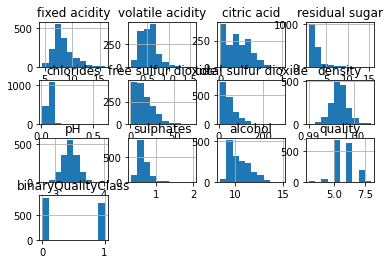

In [386]:
redWineData.hist()

In [387]:
redWineData.qualityClass.value_counts()

Fair     734
Good     638
Loyal    217
Bad       10
Name: qualityClass, dtype: int64

### Bar chart
Features vs Quality Class(our result)
In this section we used bar chart with few features. We added categorical columns on some numeric valued feature.
Because when we use bar chart with high distribution valued feature against our expected result, it wasn't showing understandable.
The following bar charts show how the categorized features are being dividing by the expected results.
* 1. is_citric_acid versus quality class
* 2. alcoholClass versus quality class
* 3. sugarClass versus quality class
* 4. chlodidesClass versus quality class

In [388]:
def bar_chart(feature):
    bad = redWineData[redWineData['qualityClass'] == 'Bad'][feature].value_counts()
    fair = redWineData[redWineData['qualityClass'] == 'Fair'][feature].value_counts()
    good = redWineData[redWineData['qualityClass'] == 'Good'][feature].value_counts()
    loyal = redWineData[redWineData['qualityClass'] == 'Loyal'][feature].value_counts()
    df = pd.DataFrame([bad,fair,good,loyal])
    df.index = ['Bad', 'Fair','Good','Loyal']
    df.plot(kind='bar',stacked=True, figsize=(10,10))

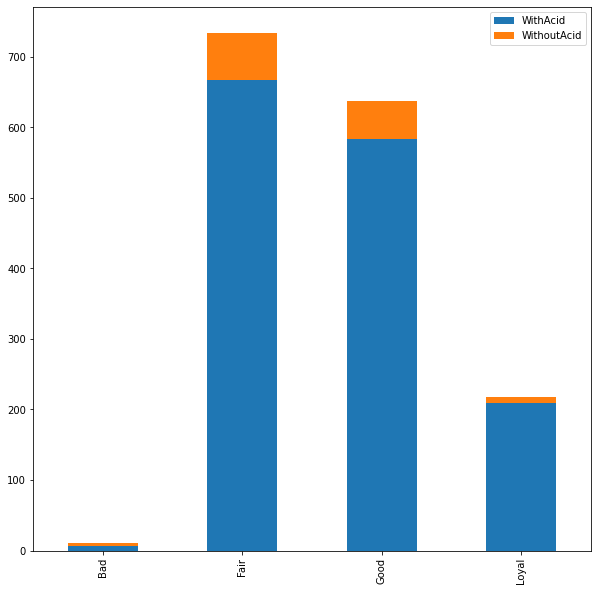

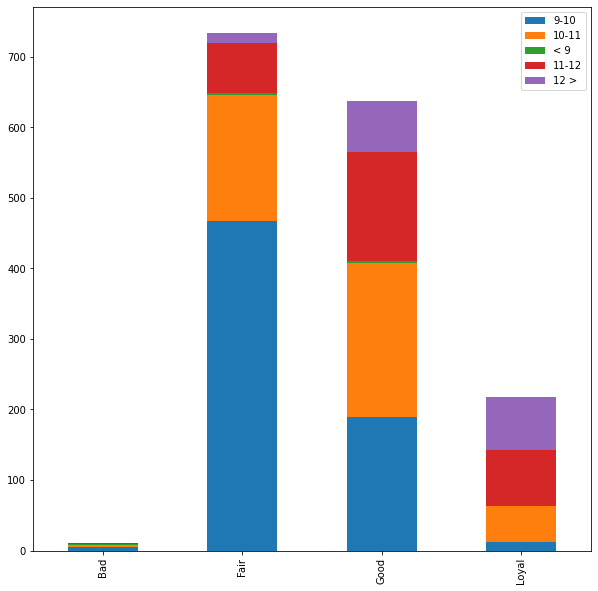

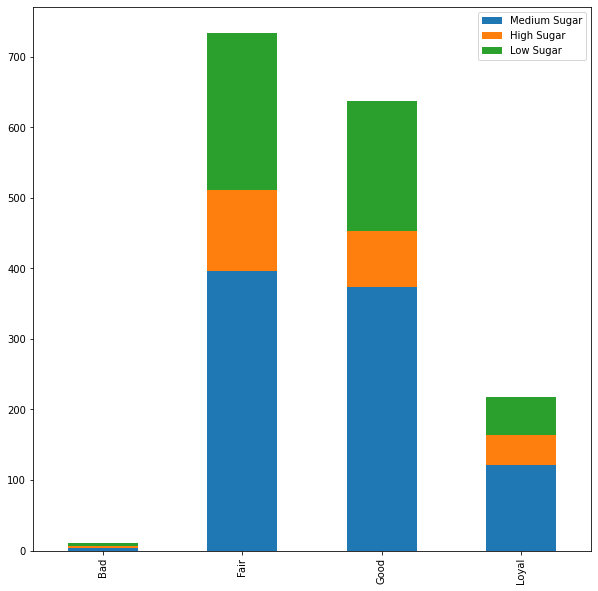

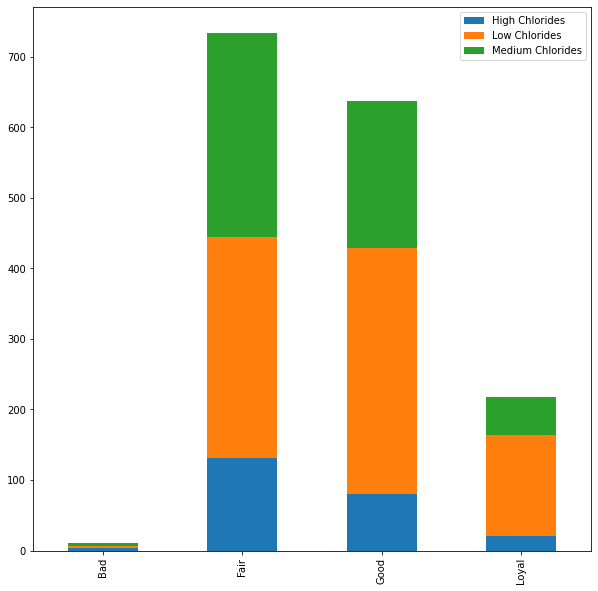

In [389]:
bar_chart('is_citric_acid')
bar_chart('alcoholClass')
bar_chart('sugarClass')
bar_chart('chloridesClass')

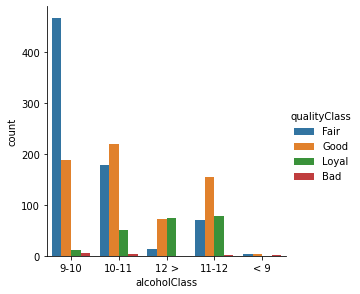

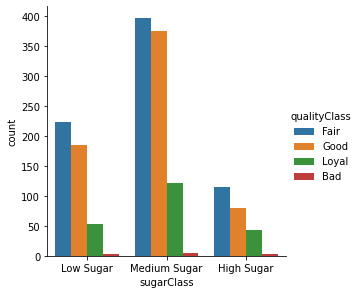

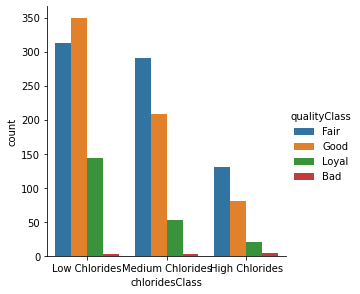

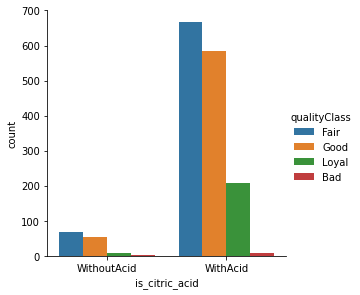

In [390]:
sns.catplot(x="alcoholClass", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

sns.catplot(x="sugarClass", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

sns.catplot(x="chloridesClass", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

sns.catplot(x="is_citric_acid", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

### Seaborn plot
Our dataset also have numeric features. This plot shows more suitable for precise values.
For example every wine have 3 types of acid,then have its own amount of acidity. These amount of data
represented too precise number. That's why we can't use bar chart or something similar one.

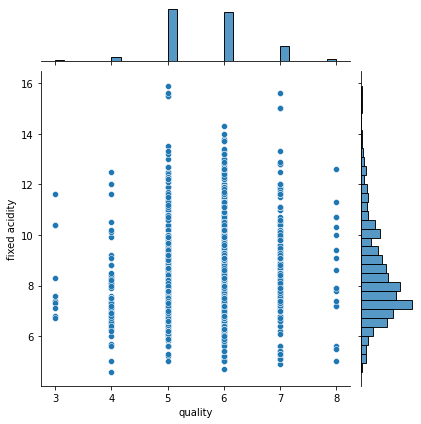

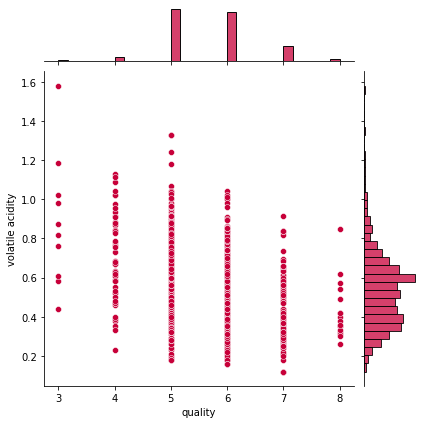

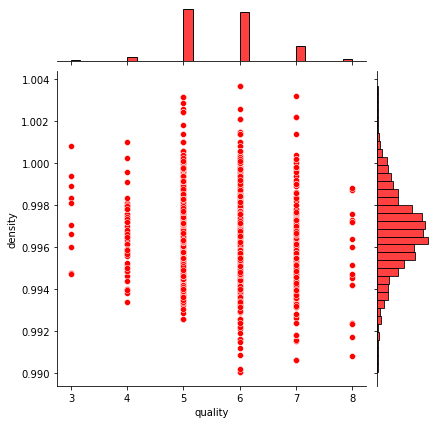

In [391]:
sns.jointplot(x="quality", y = "fixed acidity", data = redWineData)
sns.jointplot(x="quality", y = "volatile acidity", data = redWineData, color='#C70039')
sns.jointplot(x="quality", y = "density", data = redWineData, color='Red',)

### Box plot
In this section we also compare fixed acidity(numeric values) versus alcohol class. It is similar to previous
plot(Scatter plot). Box plot mean representing goal based on arithmetic mean on the all values. And we can
see the know how much the value is less than average or more.


In [392]:
def box_plot(xfeature, yfeature):
    fig, ax = mt.subplots(figsize=(10,6))
    box = sns.boxplot(x=xfeature,y=yfeature, hue="is_citric_acid", data=redWineData)
    fig.subplots_adjust(bottom=0.2)
    mt.tight_layout()

alhohol class vs fixed acidity
sugar class vs fixed acidity

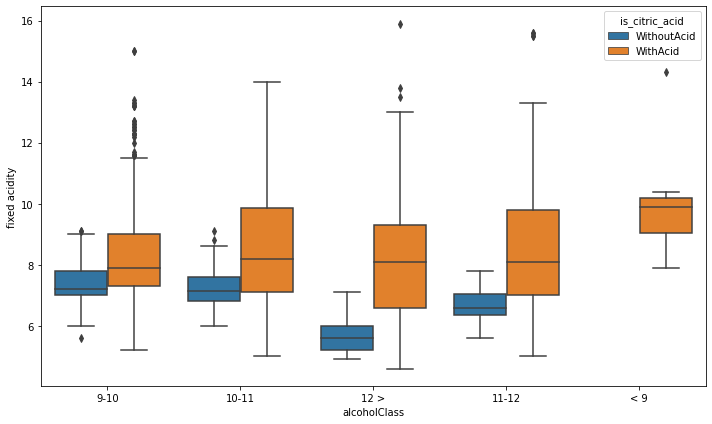

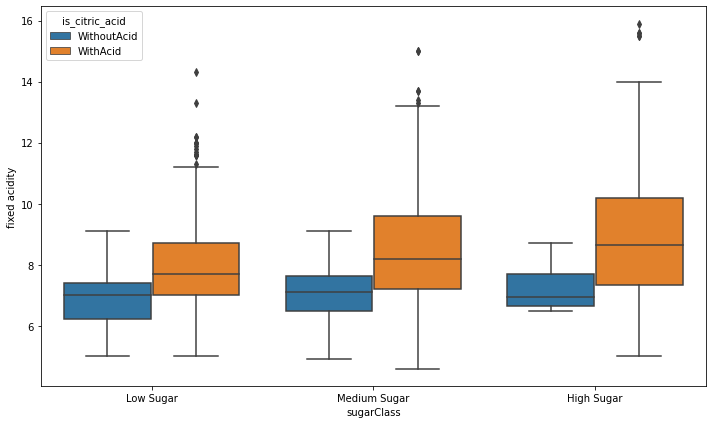

In [393]:
box_plot('alcoholClass', 'fixed acidity')
box_plot('sugarClass', 'fixed acidity')

### Seaborn distribution plot

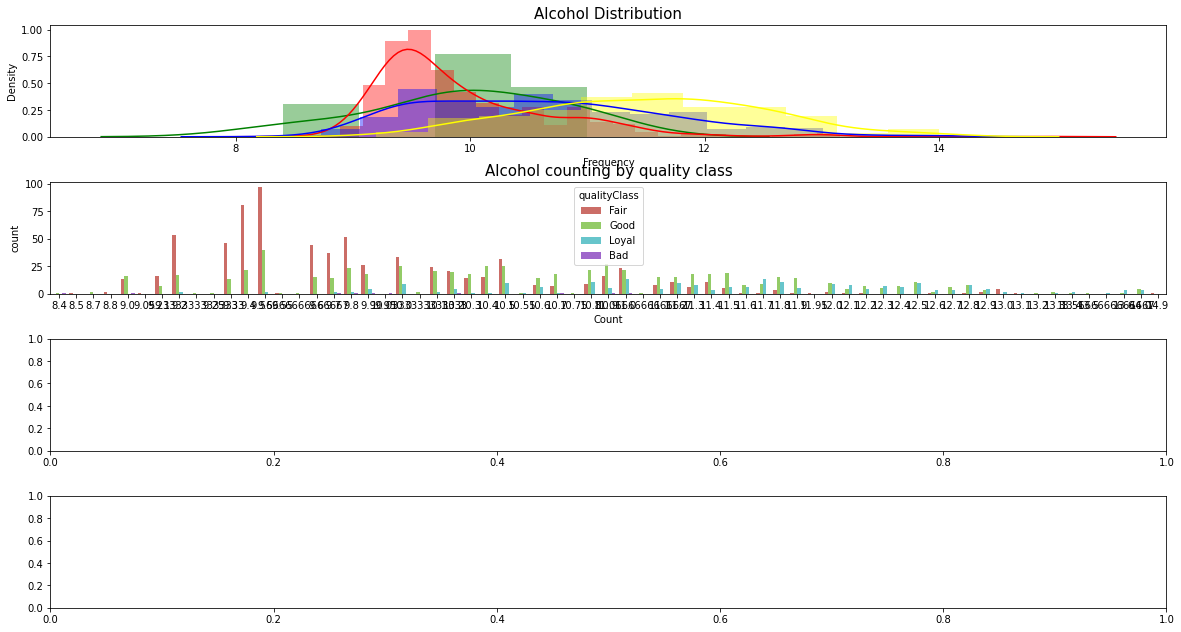

In [394]:
data_bad = redWineData[redWineData["qualityClass"] == 'Bad']
data_fair = redWineData[redWineData["qualityClass"] == 'Fair']
data_good = redWineData[redWineData["qualityClass"] == 'Good']
data_loyal = redWineData[redWineData["qualityClass"] == 'Loyal']
fig, ax = mt.subplots(nrows=4, figsize=(20,12))
mt.subplots_adjust(hspace = 0.4, top = 0.8)
g1 = sns.distplot(data_bad["alcohol"], ax=ax[0],color="g")
g1 = sns.distplot(data_fair["alcohol"], ax=ax[0],color='r')
g1 = sns.distplot(data_good["alcohol"], ax=ax[0],color='blue')
g1 = sns.distplot(data_loyal["alcohol"], ax=ax[0],color='yellow')
g1.set_title("Alcohol Distribution", fontsize=15)
g1.set_xlabel("Alcohol")
g1.set_xlabel("Frequency")
g2 = sns.countplot(x="alcohol",data=redWineData,
palette="hls", ax=ax[1],
hue = "qualityClass")
g2.set_title("Alcohol counting by quality class", fontsize=15)
g2.set_xlabel("Alcohol classification")
g2.set_xlabel("Count")
mt.show()

## SCALING VALUES

In [395]:
numvars = ['pH', 'fixed acidity', 'volatile acidity', 'free sulfur dioxide',
'total sulfur dioxide', 'density', 'sulphates']
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(redWineData[numvars])
                           ,columns = numvars)
numdata_std['binaryQualityClass'] = redWineData['binaryQualityClass']

## ENCODING CATEGORICAL FEATURES

In [396]:

#categorical variables labels
catvars = ['alcoholClass', 'sugarClass', 'chloridesClass', 'qualityClass','is_citric_acid']
d = defaultdict(LabelEncoder)
# Encoding the variable
lecatdata = redWineData[catvars].apply(lambda x: d[x.name].fit_transform(x))
# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", redWineData[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())
#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(redWineData[catvars])

alcoholClass :  ['9-10' '10-11' '12 >' '11-12' '< 9']
alcoholClass :  [3 0 2 1 4]
sugarClass :  ['Low Sugar' 'Medium Sugar' 'High Sugar']
sugarClass :  [1 2 0]
chloridesClass :  ['Low Chlorides' 'Medium Chlorides' 'High Chlorides']
chloridesClass :  [1 2 0]
qualityClass :  ['Fair' 'Good' 'Loyal' 'Bad']
qualityClass :  [1 2 3 0]
is_citric_acid :  ['WithoutAcid' 'WithAcid']
is_citric_acid :  [1 0]


In [397]:
data_clean = pd.concat([dummyvars,numdata_std],axis=1)
print("Data shape:",data_clean.shape)
data_clean.info()

Data shape: (1599, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   alcoholClass_10-11               1599 non-null   uint8  
 1   alcoholClass_11-12               1599 non-null   uint8  
 2   alcoholClass_12 >                1599 non-null   uint8  
 3   alcoholClass_9-10                1599 non-null   uint8  
 4   alcoholClass_< 9                 1599 non-null   uint8  
 5   sugarClass_High Sugar            1599 non-null   uint8  
 6   sugarClass_Low Sugar             1599 non-null   uint8  
 7   sugarClass_Medium Sugar          1599 non-null   uint8  
 8   chloridesClass_High Chlorides    1599 non-null   uint8  
 9   chloridesClass_Low Chlorides     1599 non-null   uint8  
 10  chloridesClass_Medium Chlorides  1599 non-null   uint8  
 11  qualityClass_Bad                 1599 non-null   uint8  
 1

### Correlation using heatmap

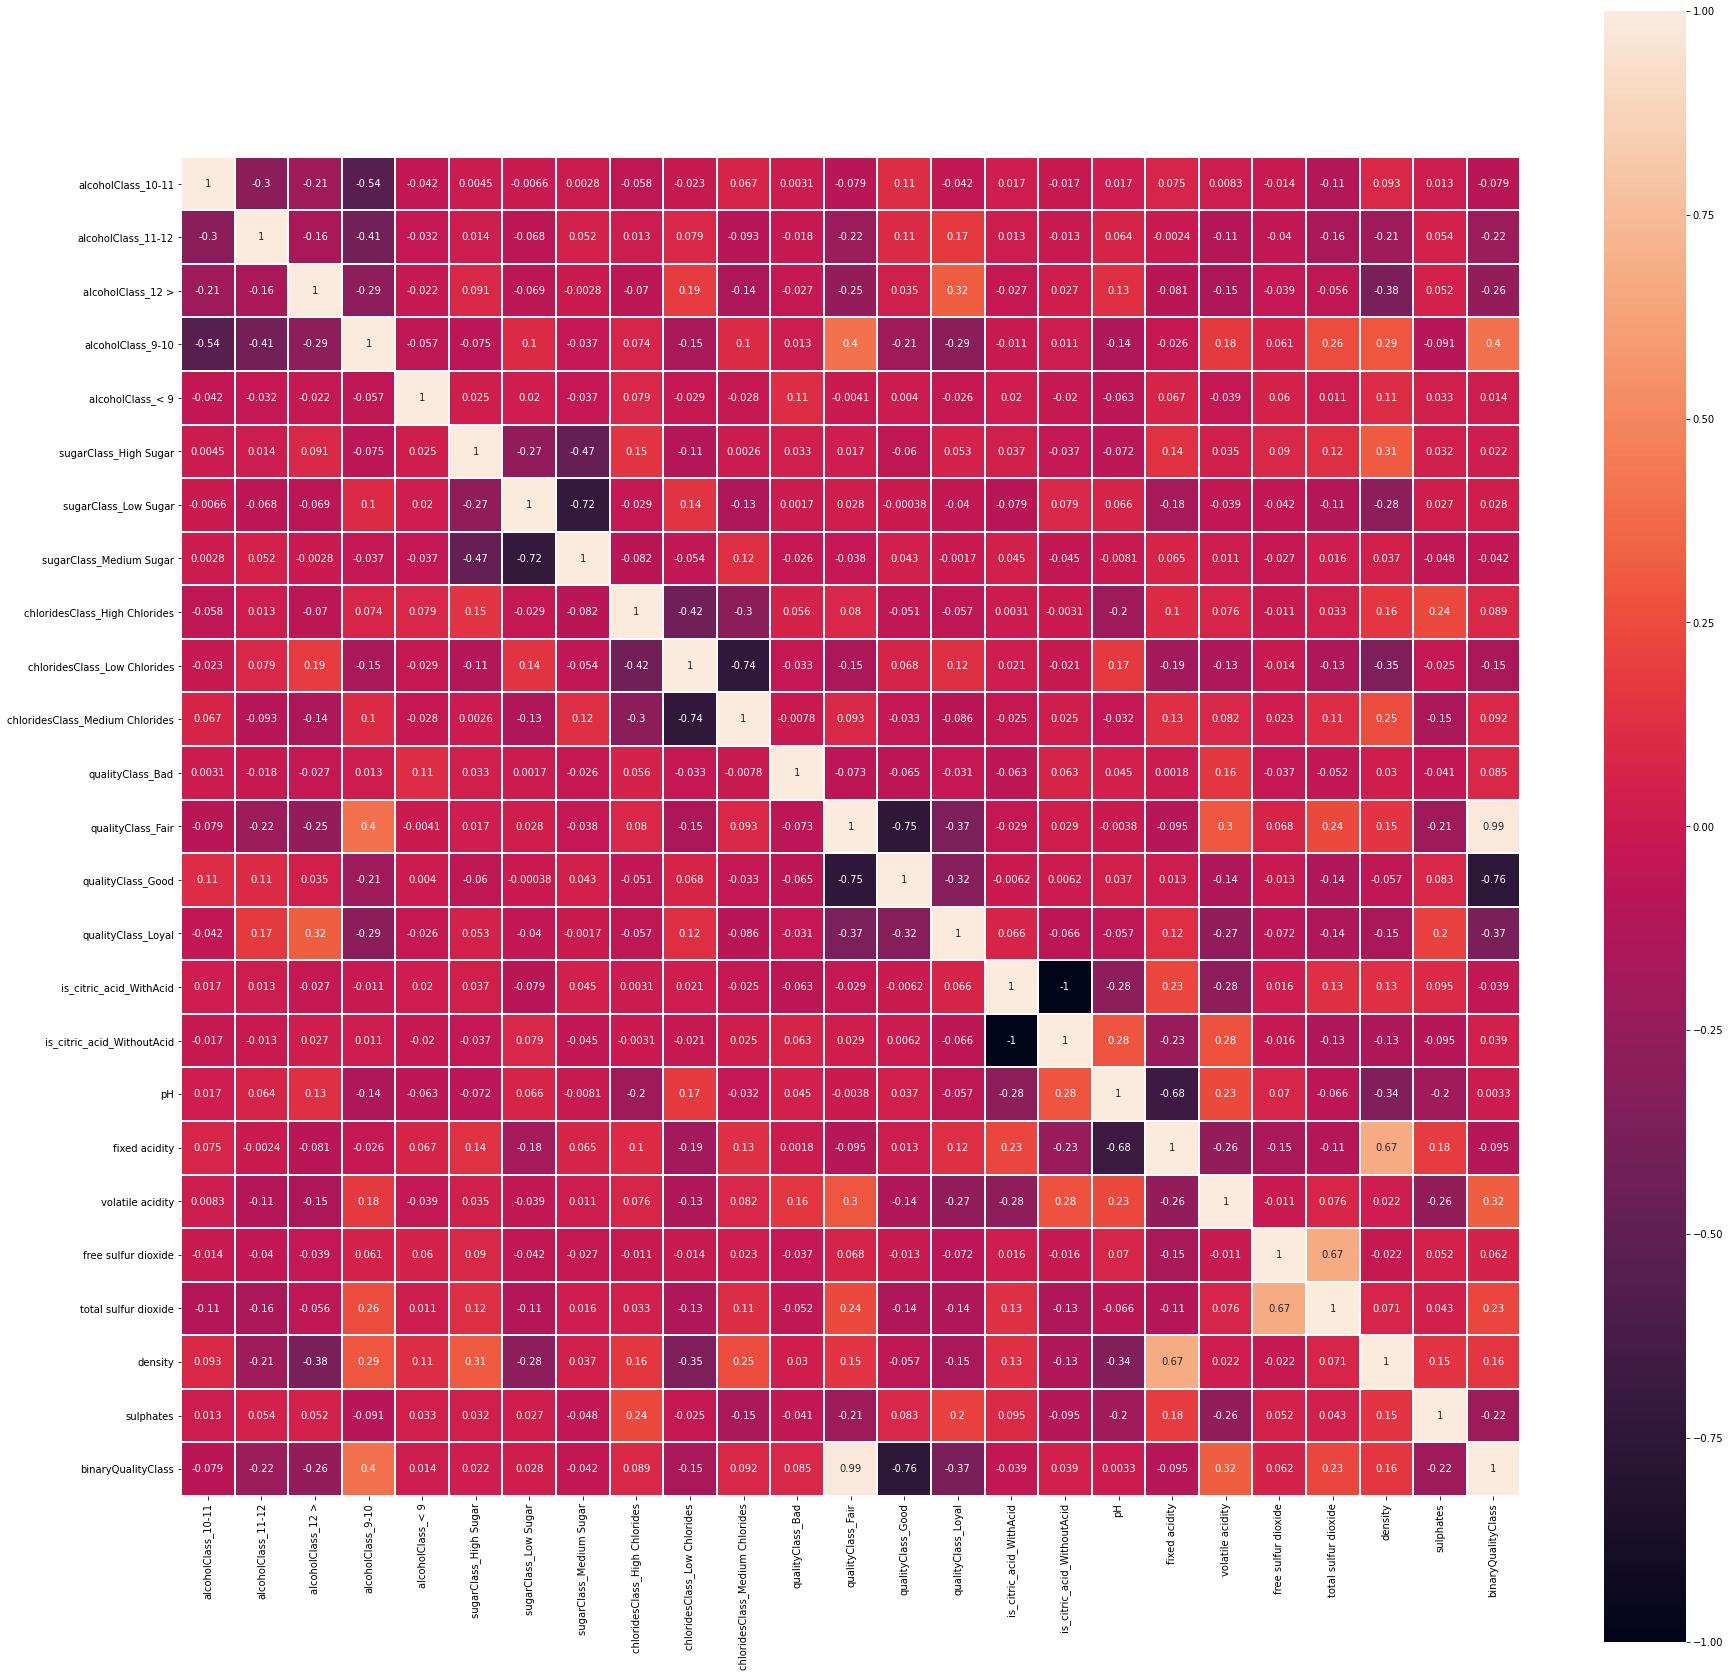

In [398]:
mt.figure(figsize=(30,30))
sns.heatmap(data_clean.corr(),linewidths=0.1,vmax=1.0,
square=True, linecolor='white', annot=True)
mt.show()


# Splitting data into train & test

In [399]:
#
X_clean = data_clean.drop('binaryQualityClass', axis=1)
y_clean = data_clean['binaryQualityClass']
X_train, X_test, y_train, y_test = train_test_split(X_clean,y_clean,test_size=0.2,
                                                    random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1279, 24)
(1279,)
(320, 24)
(320,)


# Model selection
## KNN Classifier

In [400]:
error = []
train_scores = []
test_scores = []
# Calculating error for K values between 1 and 100
for i in range (1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train,y_train))
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    test_scores.append(knn.score(X_test,y_test))

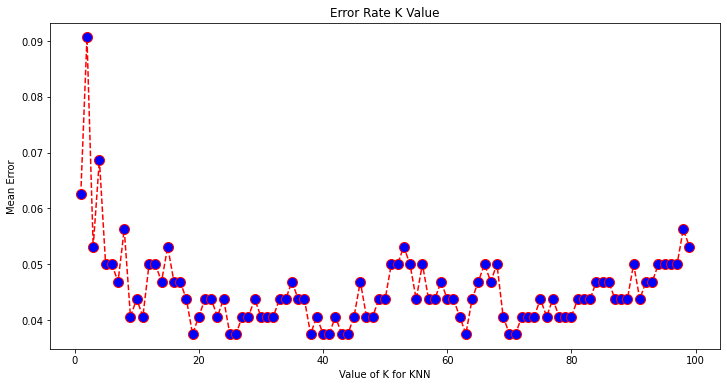

In [401]:
get_err_rate( error, range(1, 100))

Max test score 96.25 % and k = 18


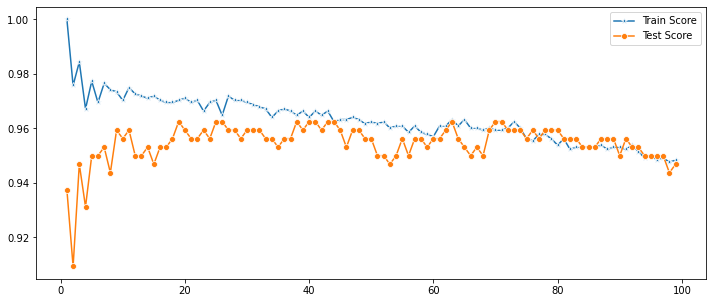

In [402]:
get_max_score(test_scores)
get_lcurve(train_scores,test_scores)


### ROC Curves and AUC

75      1
1283    0
408     0
1281    0
1118    0
       ..
890     1
146     1
1551    1
1209    0
1220    0
Name: binaryQualityClass, Length: 320, dtype: int32


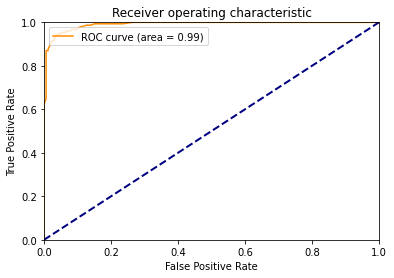

Cross Validation Accuracy: 0.93 (+/- 0.01)
Cross Validation Precision: 0.91 (+/- 0.02)
Cross Validation Recall: 0.93 (+/- 0.00)
Cross Validation roc_auc: 0.98 (+/- 0.01)
------------------------------
Cross Validation Accuracy: 0.85 (+/- 0.07)
Cross Validation Precision: 0.92 (+/- 0.08)
Cross Validation Recall: 0.77 (+/- 0.06)
Cross Validation roc_auc: 0.94 (+/- 0.05)


In [403]:
#print(X_test)
print(y_test)
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
get_roc(y_test, y_pred_proba)
get_eval1(knn,X_clean,y_clean)
print("-"*30)
get_eval2(knn,X_train,y_train,X_test, y_test)

In [404]:
param_grid = {'n_neighbors':np.arange(1,100)}
knn1 = KNeighborsClassifier()
knn_cv= GridSearchCV(knn1,param_grid,cv=5, scoring='roc_auc')
knn_cv.fit(X_clean,y_clean)
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9933458184429573
Best Parameters: {'n_neighbors': 38}


In [405]:
modelKnn=KNeighborsClassifier(n_neighbors=18)
modelKnn.fit(X_train,y_train)


KNeighborsClassifier(n_neighbors=18)

In [406]:
pred_knn=modelKnn.predict(X_test)
print(confusion_matrix(y_test, pred_knn))
print(classification_report(y_test, pred_knn))

[[160   6]
 [  8 146]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       166
           1       0.96      0.95      0.95       154

    accuracy                           0.96       320
   macro avg       0.96      0.96      0.96       320
weighted avg       0.96      0.96      0.96       320



<module 'matplotlib.pyplot' from 'c:\\users\\norov\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

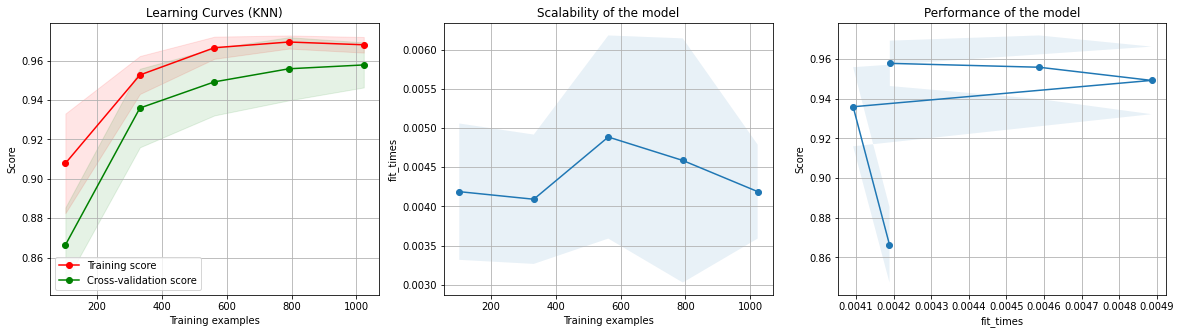

In [407]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = r"Learning Curves (KNN)"
plot_learning_curve(modelKnn, title, X_train, y_train, axes=None, ylim=None,
cv=cv, n_jobs=4)

## SVM Model trainig

In [408]:
svm = SVC(gamma=0.01, C = 200)
svc = CalibratedClassifierCV(svm)
svc.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=200, gamma=0.01))

In [409]:
pred_svc = svc.predict(X_test)
print("Confusion matrix: ", confusion_matrix(y_test, pred_svc))
print("Classification report: ", classification_report(y_test, pred_svc))
print("Accuracy score: ", accuracy_score(y_test, pred_svc))

Confusion matrix:  [[166   0]
 [  0 154]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       154

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy score:  1.0


In [410]:
train_scores_svc = cross_val_score(svc, X_train, y_train, cv=10,
scoring="accuracy")
test_scores_svc = cross_val_score(svc, X_test, y_test, cv=10,
scoring="accuracy")
print("Train scores: ",train_scores_svc)
print("Test scores: ", test_scores_svc)


Train scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test scores:  [1.      1.      0.96875 1.      1.      1.      1.      1.      1.
 1.     ]


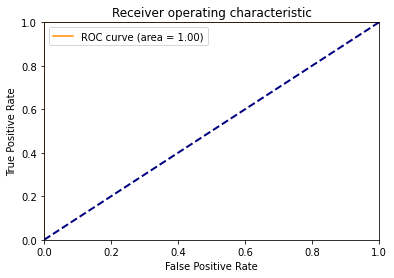

In [411]:
get_roc(y_test, pred_svc)

<module 'matplotlib.pyplot' from 'c:\\users\\norov\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

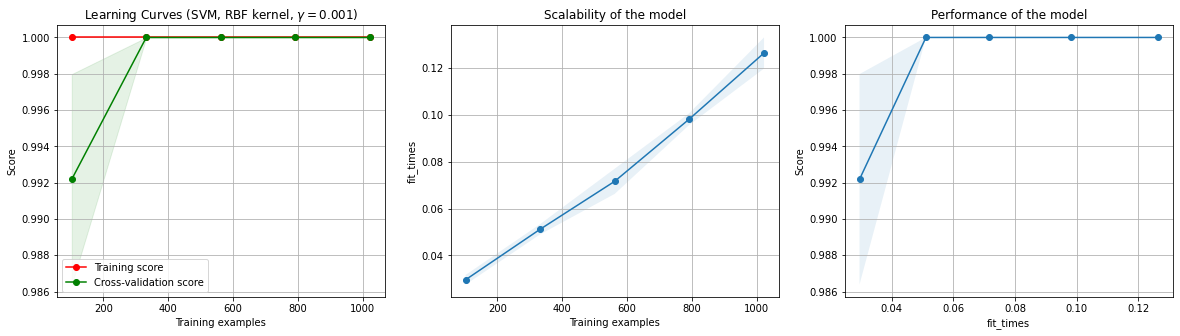

In [412]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(svc, title, X_train, y_train, axes=None, ylim=None,
cv=cv, n_jobs=4)

## Decision tree classifier


In [413]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train,y_train)
dt_accuracy= dt.score(X_test,y_test)
print ("Accuracy : ",dt_accuracy)


Accuracy :  1.0


In [414]:
ypred=dt.predict(X_test)
print("Predicted values:")
print(ypred)


Predicted values:
[1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0
 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0
 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1
 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0
 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0]


In [415]:
#TUNING

In [416]:
# Create a Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",
        random_state = 100,max_depth=3, min_samples_leaf=5)
    # Performing training
    clf_gini.fit(X_train,y_train)
    return clf_gini
# this function makes predictions
def prediction(X_test, clf_object):
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred
# this function calculates accuracy
def cal_accuracy(y_test, y_pred):
    CM2= confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: ",CM2)
    Accuracy2=accuracy_score(y_test,y_pred)*100
    print ("Accuracy : ", Accuracy2)
    C_report = classification_report(y_test, y_pred)
    print("Report : ", C_report)


In [417]:
clf_gini = train_using_gini(X_train, X_test, y_train)
# Operational Phase
print("Results Using Gini Index:")
# Prediction using gini
y_pred_gini = prediction(X_test, clf_gini)
cal_accuracy(y_test, y_pred_gini)

Results Using Gini Index:
Predicted values:
[1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0
 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0
 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1
 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0
 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0]
Confusion Matrix:  [[166   0]
 [  0 154]]
Accuracy :  100.0
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       154

    accuracy                           1.00       320
   macro avg      

In [418]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
train_sizes, train_scores, test_scores = \
    learning_curve(DecisionTreeClassifier(criterion = "gini",
    random_state = 100,max_depth=3,min_samples_leaf=5),X_clean,y_clean,cv=5,
    scoring='accuracy',n_jobs=1,train_sizes = np.linspace(0.01,1,50),verbose=1)


[learning_curve] Training set sizes: [  12   38   64   90  116  141  167  193  219  245  271  297  322  348
  374  400  426  452  477  503  529  555  581  607  632  658  684  710
  736  762  788  813  839  865  891  917  943  968  994 1020 1046 1072
 1098 1123 1149 1175 1201 1227 1253 1279]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished


In [419]:
# Calculate mean and stadandard deviation
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores, axis=1)


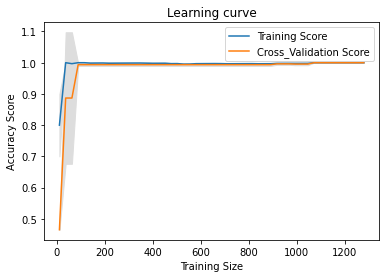

In [420]:
# PLot the Learning curve
mt.plot(train_sizes,train_mean,label='Training Score')
mt.plot(train_sizes,test_mean,label='Cross_Validation Score')
#lets see how the accuracy is varying
mt.fill_between(train_sizes,train_mean-train_std, train_mean+train_std,
    color='#DDDDDD')
mt.fill_between(train_sizes,test_mean-test_std, test_mean+test_std,
    color='#DDDDDD')
mt.title('Learning curve')
mt.xlabel('Training Size')
mt.ylabel('Accuracy Score')
mt.legend(loc='best')

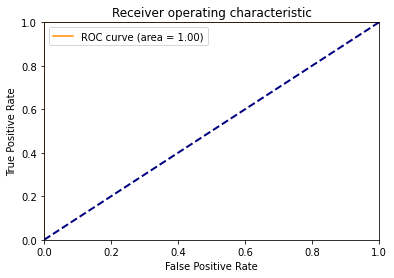

In [421]:
get_roc(y_test, y_pred_gini)

## Train Logistic Regression


In [422]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
lr.score(X_test, y_test)

1.0

Validation curve for Logistic Regression


In [423]:
# validation curve for Logistic Regression
pred_lr = lr.predict(X_test)
print("Confusion matrix: ", confusion_matrix(y_test, pred_lr))
print("Classification report: ", classification_report(y_test, pred_lr))
print("Accuracy score: ", accuracy_score(y_test, pred_lr))

Confusion matrix:  [[166   0]
 [  0 154]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       154

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy score:  1.0


In [424]:
train_scores_lr = cross_val_score(lr, X_train, y_train, cv=10,
scoring="accuracy")
test_scores_lr = cross_val_score(lr, X_test, y_test, cv=10,
scoring="accuracy")
print("Train scores: ",train_scores_lr)
print("Test scores: ", train_scores_lr)

Train scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


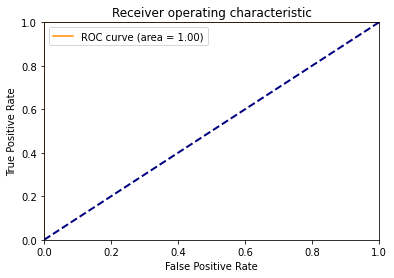

In [425]:
get_roc(y_test, pred_svc)

<module 'matplotlib.pyplot' from 'c:\\users\\norov\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

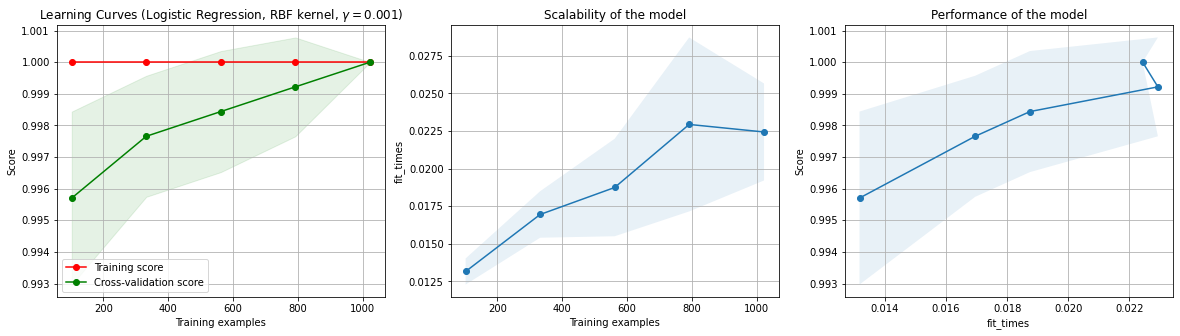

In [426]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = r"Learning Curves (Logistic Regression, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(lr, title, X_train, y_train, axes=None, ylim=None,
cv=cv, n_jobs=4)

## RIDGE Classifier

In [427]:
from sklearn.linear_model import RidgeClassifier
rdg = RidgeClassifier()
rdg.fit(X_train, y_train)
rdg.predict(X_test)
rdg.score(X_test, y_test)

1.0

In [428]:
pred_rdg = rdg.predict(X_test)
print("Confusion matrix: ", confusion_matrix(y_test, pred_rdg))
print("Classification report: ", classification_report(y_test, pred_rdg))
print("Accuracy score: ", accuracy_score(y_test, pred_rdg))

Confusion matrix:  [[166   0]
 [  0 154]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       154

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy score:  1.0


In [429]:
train_scores_rdg = cross_val_score(rdg, X_train, y_train, cv=10,
scoring="accuracy")
test_scores_rdg = cross_val_score(rdg, X_test, y_test, cv=10,
scoring="accuracy")
print("Train scores: ",train_scores_rdg)
print("Test scores: ", train_scores_rdg)

Train scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


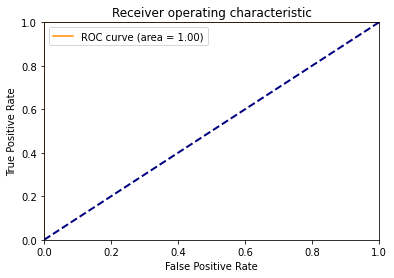

In [430]:
get_roc(y_test, pred_rdg)

<module 'matplotlib.pyplot' from 'c:\\users\\norov\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

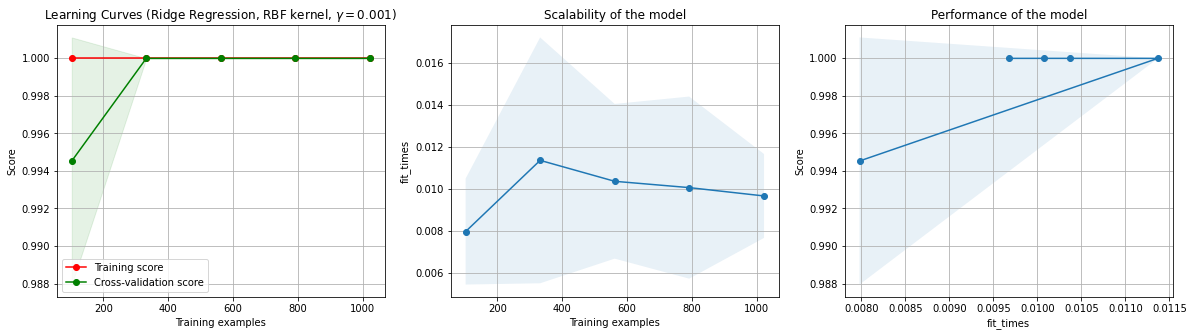

In [431]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = r"Learning Curves (Ridge Regression, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(rdg, title, X_train, y_train, axes=None, ylim=None,
cv=cv, n_jobs=4)


In [432]:
#Grid Search for random forest classifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10],
              'random_state': [0, 1]}
base_estimator = RandomForestClassifier()
having = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                             factor=2, resource='n_estimators',
                             max_resources=30).fit(X_train, y_train)
having.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=16, random_state=1)

## ENSEMBLE Random forest

In [433]:
rf = RandomForestClassifier(n_estimators=16, random_state=1)
rf.fit(X_train, y_train)
rf.predict(X_test)
rf.score(X_test, y_test)

1.0

In [434]:
pred_rf = rf.predict(X_test)
print("Confusion matrix: ", confusion_matrix(y_test, pred_rf))
print("Classification report: ", classification_report(y_test, pred_rf))
print("Accuracy score: ", accuracy_score(y_test, pred_rf))

Confusion matrix:  [[166   0]
 [  0 154]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       154

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy score:  1.0


In [435]:
train_scores_rf = cross_val_score(rdg, X_train, y_train, cv=10,
scoring="accuracy")
test_scores_rf = cross_val_score(rdg, X_test, y_test, cv=10,
scoring="accuracy")
print("Train scores: ",train_scores_rf)
print("Test scores: ", train_scores_rf)

Train scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


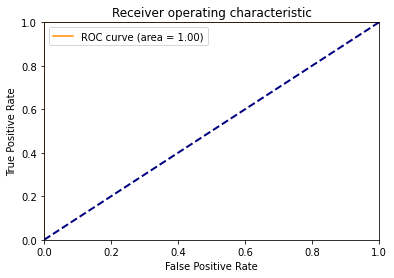

In [436]:
get_roc(y_test, pred_rf)

<module 'matplotlib.pyplot' from 'c:\\users\\norov\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

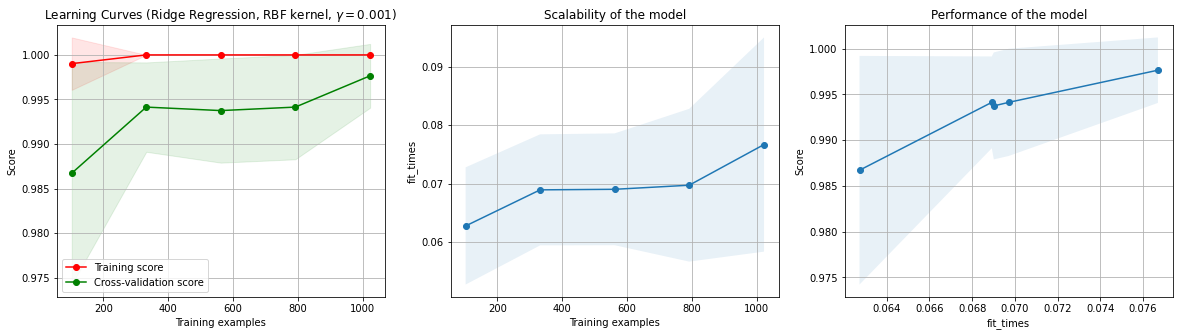

In [437]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = r"Learning Curves (Ridge Regression, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(rf, title, X_train, y_train, axes=None, ylim=None,
cv=cv, n_jobs=4)

## VOTING CLASSIFIER
1.KNN 2.SVM 3.DTree 4.Logistic regression 5.Ridge

In [438]:
from sklearn.ensemble import VotingClassifier
voting_classifier = VotingClassifier([('lr', LogisticRegression()),
                                    ('dt', DecisionTreeClassifier(random_state=1)),
                                    ('knn', KNeighborsClassifier(n_neighbors=7)),
                                    ('rdg', RidgeClassifier()),
                                    ('rf', RandomForestClassifier(n_estimators=10, random_state=1))
                                    ])

voting_classifier.fit(X_train, y_train)
voting_classifier.predict(X_test)
voting_classifier.score(X_test, y_test)


1.0

## AUC Model Comparison

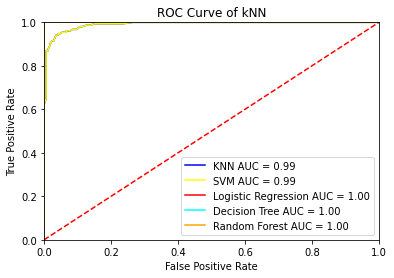

In [439]:
mt.title('Receiver Operating Characteristic')

# AUC-ROC KNN
knn_y_scores = knn.predict_proba(X_test)
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_test, knn_y_scores[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
mt.plot(knn_fpr, knn_tpr, 'b', label = 'KNN AUC = %0.2f' % knn_roc_auc, color='blue')

# AUC-ROC SVM
svc_y_scores = svc.predict_proba(X_test)
svc_fpr, svc_tpr, scv_threshold = roc_curve(y_test, knn_y_scores[:, 1])
svc_roc_auc = auc(svc_fpr, svc_tpr)
mt.plot(svc_fpr, svc_tpr, 'b', label = 'SVM AUC = %0.2f' % svc_roc_auc, color='yellow')

# AUC-ROC LogisticRegression
lr_y_scores = lr.predict_proba(X_test)
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr_y_scores[:, 1])
lr_roc_auc = auc(lr_fpr, lr_tpr)
mt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc, color='red')

# AUC-ROC Decision Tree
dt_y_scores = dt.predict_proba(X_test)
dt_fpr, dt_tpr, dt_threshold = roc_curve(y_test, dt_y_scores[:, 1])
dt_roc_auc = auc(dt_fpr, dt_tpr)
mt.plot(dt_fpr, dt_tpr, 'b', label = 'Decision Tree AUC = %0.2f' % dt_roc_auc, color='cyan')

# AUC-ROC Random Forest
rf_y_scores = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_y_scores[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
mt.plot(rf_fpr, rf_tpr, 'b', label = 'Random Forest AUC = %0.2f' % rf_roc_auc, color='orange')


mt.legend(loc = 'lower right')
mt.plot([0, 1], [0, 1],'r--')
mt.xlim([0, 1])
mt.ylim([0, 1])
mt.ylabel('True Positive Rate')
mt.xlabel('False Positive Rate')
mt.title('ROC Curve of kNN')
mt.show()

## Principal Component Analysis (PCA)

In [440]:
pca = PCA()
pca.fit_transform(data_clean)

array([[-1.26340000e+00, -2.69414997e-01,  1.48679771e+00, ...,
         1.36475184e-16,  5.09555482e-16,  5.00675352e-17],
       [-4.30766581e-01,  1.65117045e+00,  1.39019073e+00, ...,
         7.22154428e-15,  2.84847695e-15,  2.48352314e-16],
       [-2.24283952e-01,  7.21125901e-01,  1.36414322e+00, ...,
        -9.47211045e-16, -1.61584953e-15,  3.05648107e-16],
       ...,
       [-1.29829719e+00,  1.76012716e-01, -1.42746805e+00, ...,
        -7.33363276e-17, -1.71180033e-17,  8.26803711e-18],
       [-2.32572143e+00,  8.23852450e-01, -3.81244062e-01, ...,
        -1.44468348e-16, -1.43516322e-17, -2.92560809e-17],
       [-1.08145338e+00, -5.60060171e-01, -1.60826796e+00, ...,
        -2.28648885e-17,  7.14078246e-17,  3.41725679e-18]])

In [441]:
covariance=pca.get_covariance()

In [442]:
explained_variance=pca.explained_variance_
explained_variance

array([2.38075446e+00, 1.76421842e+00, 1.38514005e+00, 8.04839539e-01,
       6.48943921e-01, 5.40145481e-01, 4.01617980e-01, 3.53579393e-01,
       3.21716744e-01, 2.66538043e-01, 2.44706523e-01, 1.96676228e-01,
       1.62241292e-01, 1.37408096e-01, 1.21457770e-01, 1.09350769e-01,
       4.27776685e-02, 9.72332273e-03, 4.90553670e-03, 2.73061225e-30,
       1.09698159e-30, 7.19656023e-31, 9.15880860e-32, 4.29085142e-32,
       8.54391837e-33])

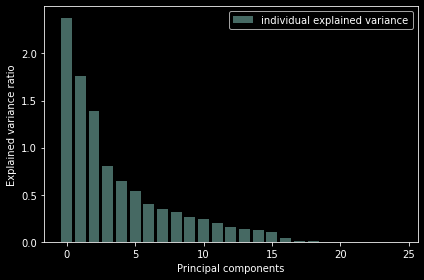

In [443]:
with mt.style.context('dark_background'):
    mt.figure(figsize=(6, 4))
    mt.bar(range(25), explained_variance, alpha=0.5, align='center',
            label='individual explained variance' )
    mt.ylabel('Explained variance ratio')
    mt.xlabel('Principal components')
    mt.legend(loc='best')
    mt.tight_layout()

<function matplotlib.pyplot.show(close=None, block=None)>

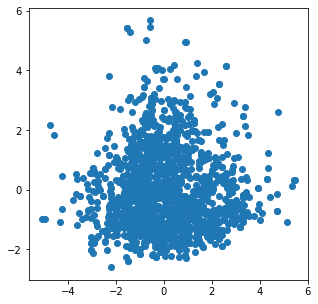

In [444]:
N=data_clean.values
pca = PCA(n_components=2)
x = pca.fit_transform(N)
mt.figure(figsize = (5,5))
mt.scatter(x[:,0],x[:,1])
mt.show

## ML interpretation technique (SHAP)

In [445]:
import shap
shap.initjs()

In [446]:
X = redWineData.drop(['quality','chloridesClass', 'qualityClass', 'alcoholClass','sugarClass','is_citric_acid'], axis = 1)
Y = redWineData['quality']
X_featurenames = X.columns

In [447]:
X_train_shap, X_test_shap, Y_train_shap, Y_test_shap = train_test_split(X, Y, test_size = 0.2,
                                                                        random_state = 30)

In [448]:
shap_model = RandomForestClassifier(max_depth = 5, random_state = 0, n_estimators = 16)
shap_model.fit(X_train_shap, Y_train_shap)

RandomForestClassifier(max_depth=5, n_estimators=16, random_state=0)

<AxesSubplot:>

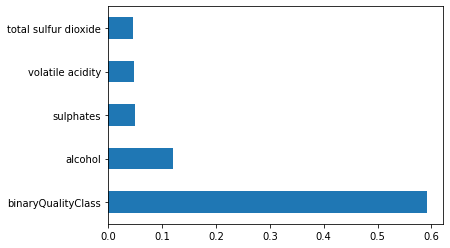

In [449]:
feat_importances = pd.Series(shap_model.feature_importances_, index = X_featurenames)
feat_importances.nlargest(5).plot(kind = 'barh')

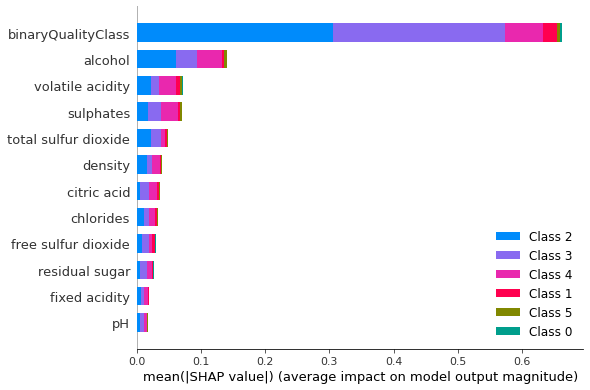

[[-1.19621066e-04 -2.12269394e-03 -1.84665749e-04 ...  1.79864048e-03
  -7.76459066e-04 -4.53549160e-03]
 [-1.86851816e-03  2.15705297e-02  2.60234913e-04 ...  1.11534088e-03
  -4.40418652e-03  1.74671336e-02]
 [ 1.47814838e-04 -1.93840686e-06  1.30817118e-03 ... -3.16224898e-05
  -7.08211476e-04  5.58297289e-03]
 ...
 [ 9.98199464e-05 -1.51830254e-04  1.00800080e-03 ... -4.56431522e-04
  -7.07821913e-04 -2.91607097e-03]
 [ 4.65899770e-04 -1.03977447e-03  2.22003936e-03 ... -8.70104968e-04
   5.55215729e-04  4.06822385e-03]
 [-4.79864815e-04 -7.78190823e-04 -3.09019639e-04 ... -3.91054536e-04
  -5.68241593e-04  2.74714677e-03]]


In [450]:
ex = shap.TreeExplainer(shap_model)
shap_values = ex.shap_values(X_test_shap)
shap.summary_plot(shap_values, X_test_shap)
print(shap_values[0])

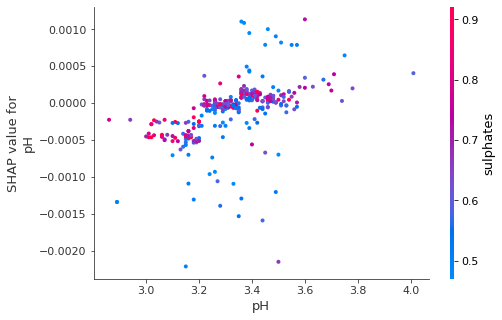

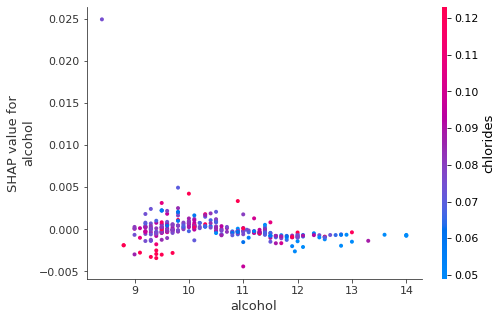

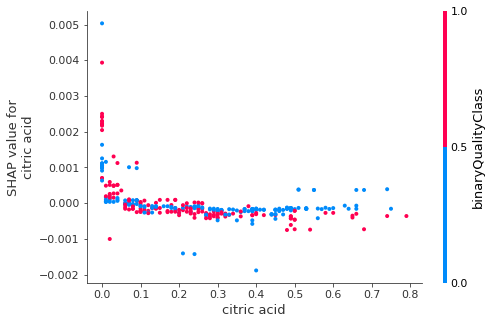

In [451]:
shap.dependence_plot('pH', shap_values[0], X_test_shap)
shap.dependence_plot('alcohol', shap_values[0], X_test_shap)
shap.dependence_plot('citric acid', shap_values[0], X_test_shap)

In [452]:
ex = shap.KernelExplainer(shap_model.predict, X_train_shap)
shap_values = ex.shap_values(X_test_shap.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, X_test_shap.iloc[0,:])

Using 1279 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## AUTO ML
AutoML with TPOT

In [453]:
#from tpot import TPOTClassifier
#tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
#tpot.fit(X_train, y_train)
#tpot.score(X_test, y_test)
